In [74]:
import xarray as xr
import numpy as np
import warnings
import matplotlib.pyplot as plt
import pandas as pd
warnings.filterwarnings('ignore')
plt.style.use('default')
import os
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box, mapping
import geopandas as gpd
from matplotlib import cm
import texttable
from xclim import ensembles
import global_land_mask
import logging
from CMIP6_ridgeplot import CMIP6_ridgeplot
import CMIP6_area_calculations
import matplotlib.dates as mdates

logging.getLogger('xclim').setLevel('ERROR')
logging.getLogger('root').setLevel('ERROR')
sns.set(font_scale=1.5, style="whitegrid")

In [75]:
def convert_to_180(ds):
 #   ds=ds.assign_coords(lat=ds.y)
    return (ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))).sortby('lon')

def convert_time(ds):
    if not ds.indexes["time"].dtype in ["datetime64[ns]"]:

        time_objects = ds.indexes['time'].to_datetimeindex() 
        ds=ds.assign_coords({"time": time_objects})                   
        ds = xr.decode_cf(ds)
        
    return ds

def create_land_ocean_mask(cmip6_grid: xr.Dataset) -> xr.DataArray:
    print("[create_land_ocean_mask] Running create_land_ocean_mask")
    lon = cmip6_grid.lon.values
    lat = cmip6_grid.lat.values
    lon_180 = xr.where(lon > 180, lon - 360, lon)
    lon_grid, lat_grid = np.meshgrid(lon_180, lat)

    mask_data = global_land_mask.globe.is_ocean(lat_grid, lon_grid).astype(int)
    #  mask_data[np.isnan(mask_data)] = np.nan

    return xr.DataArray(mask_data, coords={'lat': lat, 'lon': lon},
                        dims=['lat', 'lon'])

def resample_to_monthly(ds:xr.Dataset, var_name):
    ds = xr.where(((ds < 1.e-20) | (ds > 1e20)), np.nan, ds)
    ds = convert_to_180(ds)
    ds = ds.sel(time=slice(start_time,end_time))

    ds_lme = convert_time(ds)
    # Add land mask
    ds_lme["mask"] = create_land_ocean_mask(ds_lme)
    ds_lme = ds_lme.where(ds_lme.mask == 1)
    ds_lme = get_data_within_LME(ds_lme, var_name, LME, False)
    return ds_lme.resample(time="M").mean()

def get_area_averaged_ds(fname_perc, fname_stats,  scenario, var_name, LME):

    var_name_mean = f"{var_name}_mean"
    var_name_std = f"{var_name}_stdev"

    if os.path.exists(fname_stats) and os.path.exists(fname_perc):
        ds_stats = xr.open_dataset(fname_stats)
        ds_perc = xr.open_dataset(fname_perc)

        ds_stats = resample_to_monthly(ds_stats, var_name_mean)
        ds_perc = resample_to_monthly(ds_perc, var_name)

        # First we calculate the total area covered by the LME. The total areacello is broadcasted along time
        # axis and used later.
        ds_perc["areacello"] = CMIP6_area_calculations.calculate_areacello(ds_perc.sel(percentiles=2.5), var_name)
        total_area_lme = np.nansum(ds_perc["areacello"].isel(time=0))
        print("[calculate_areacello] Average total area {:,.2f} km2".format(total_area_lme))

        # We assess where light more than light_threshold (W/m2) is changing. For Polar cod, light_threshold is
        # the minimum light level required to feed. If the area where minimum light increases, this can be indicative
        # of areas opening up for feeding given that food levels are increasing too.
        light_threshold=1
        if var_name in ["uvb_mean"]:
            light_threshold=0.001

        # Now mask the areas for the various percentiles of low light levels where the minimum threshold is found and
        # use that to mask areacello as a function of time. This gives us monthly area where the minimum threshold is found
        # for three lower percentiles of light values (2.5, 5, and 15th percentiles)
        ds_perc2dot5 = xr.where(ds_perc[var_name].sel(percentiles=2.5)<light_threshold, np.nan, ds_perc[var_name].sel(percentiles=2.5))
        ds_perc5 = xr.where(ds_perc[var_name].sel(percentiles=5.0)<light_threshold, np.nan, ds_perc[var_name].sel(percentiles=5.0))
        ds_perc15 = xr.where(ds_perc[var_name].sel(percentiles=15)<light_threshold, np.nan, ds_perc[var_name].sel(percentiles=15))
        ds_stats = xr.where(ds_stats[var_name_mean].values<light_threshold, np.nan, ds_stats)

        # Now mask all areas with nan as a function of time to areacello.
        ds_perc["areacello_2dot5"] = xr.where(np.isnan(ds_perc2dot5), np.nan, ds_perc["areacello"])
        ds_perc["areacello_5"] = xr.where(np.isnan(ds_perc5), np.nan, ds_perc["areacello"])
        ds_perc["areacello_15"] = xr.where(np.isnan(ds_perc15), np.nan, ds_perc["areacello"])

        ds_perc = get_data_within_LME(ds_perc, var_name, LME, False)
        ds_stats = get_data_within_LME(ds_stats, var_name_mean, LME, False)

        # Average data spatially within the LME as a function of time
        ds = ds_perc.mean({"lat","lon"}, skipna=True)
        ds_s = ds_stats.mean({"lat","lon"}, skipna=True)
        ds_s = ds_s.assign(std = ds_stats[f"{var_name}_stdev"].mean(dim={"lat","lon"}))

        # The various variables needs to be added to the dataset using MEAN
        ds = ds.assign(perc_2dot5 = ds_perc[var_name].sel(percentiles=2.5).mean(dim={"lat","lon"}))
        ds = ds.assign(perc_5 = ds_perc[var_name].sel(percentiles=5).mean(dim={"lat","lon"}))
        ds = ds.assign(perc_15 = ds_perc[var_name].sel(percentiles=15).mean(dim={"lat","lon"}))
        ds = ds.assign(perc_50 = ds_perc[var_name].sel(percentiles=50).mean(dim={"lat","lon"}))
        ds = ds.assign(perc_85 = ds_perc[var_name].sel(percentiles=85).mean(dim={"lat","lon"}))
        ds = ds.assign(perc_97dot5 = ds_perc[var_name].sel(percentiles=97.5).mean(dim={"lat","lon"}))

         # The various areas needs to be added to the dataset using SUM
        ds = ds.assign(areacello_2dot5 = ds_perc["areacello_2dot5"].sum(dim={"lat","lon"}))
        ds = ds.assign(areacello_5 = ds_perc["areacello_5"].sum(dim={"lat","lon"}))
        ds = ds.assign(areacello_15 = ds_perc["areacello_15"].sum(dim={"lat","lon"}))

        # Convert datasets to Pandas dataframes
        df = ds.to_dataframe().dropna()
        df = df.reset_index()

        df_s = ds_s.to_dataframe().dropna()
        df_s = df_s.reset_index()

        # Calculate the 5 year rolling mean to avoid outliers and extremes
        # and get the trend.
        roll_years=5
        df=df.resample("A", on="time").mean()
        df_s=df_s.resample("A", on="time").mean()
        df_s["roll_mean"]=df_s[var_name_mean].rolling(roll_years).mean()
        df_s["roll_std"]=df_s[f"{var_name}_stdev"].rolling(roll_years).mean()
        df_s["model_scenario"]=scenario

        # Save to CSV file
        df_s.to_csv(f"test_{LME}.csv")
        df.to_csv(f"test_perc_{LME}.csv")

        df["model_name"]="ensemble"
        df["roll_mean_2dot5"]=df["perc_2dot5"].rolling(roll_years).mean()
        df["roll_mean_5"]=df["perc_5"].rolling(roll_years).mean()
        df["roll_mean_15"]=df["perc_15"].rolling(roll_years).mean()
        df["roll_mean_50"]=df["perc_50"].rolling(roll_years).mean()
        df["roll_mean_85"]=df["perc_85"].rolling(roll_years).mean()
        df["roll_mean_97dot5"]=df["perc_97dot5"].rolling(roll_years).mean()

        df["roll_mean_area_2dot5"]=df["areacello_2dot5"].rolling(roll_years).mean()
        df["roll_mean_area_5"]=df["areacello_5"].rolling(roll_years).mean()
        df["roll_mean_area_15"]=df["areacello_15"].rolling(roll_years).mean()

        df["model_scenario"]=scenario
        df["model_name_scenario"]=f"ensemble_{scenario}"
        unique=f"ensemble_{scenario}"
        df["unique"]=unique

        model_info={}
        model_info["model_name"]="ensemble"
        model_info["model_scenario"]=scenario
        model_info["model_var"]=var_name
        formatter="{:.2f}"
        model_info["model_min"]=formatter.format(np.nanmin(df[var_name]))
        model_info["model_max"]=formatter.format(np.nanmax(df[var_name]))
        return df,df_s, total_area_lme
    else:
        return None, None, None

In [76]:
def get_LME_records():
    lme_file='../oceanography/Shapefiles/LME66/LMEs66.shp'
    return gpd.read_file(lme_file)

def get_LME_records_plot():
    lme_file='../oceanography/Shapefiles/LME66_180/LME66_180.shp'
    return gpd.read_file(lme_file)

def create_colors(N):
    color=iter(cm.tab20b(np.linspace(0,1,N)))
    return [next(color) for c in range(N)]


def get_data_within_LME(ds,var_name,LME,create_maps):
    print("Working on LME: {}".format(LME))

    # Extract the polygon defining the boundaries of the LME
    shdf = get_LME_records()
   # for name in shdf['LME_NAME']:
   #     print(name)
    shdf_sel = shdf[ shdf['LME_NAME']==LME ]

    # Rioxarray requires x and y dimensions - we convert these back to lon and lat later.
    # We also add the projection (lat-lon) so that rioxarray can do the clipping of the data according to the
    # shapefile.
    tos=ds.rename({'lon': 'x','lat': 'y'})
    tos=tos.rio.write_crs(4326)

    # Clip the data within the LME. We have to convert the polygon geometry to a geodataframe using
    # `shapely.geometry`. The clipping of data within the polygon is done using rioxarray.clip function
    clipped = tos.rio.clip(geometries=shdf_sel.geometry.apply(mapping), crs=tos.rio.crs)
    clipped=clipped.rename({'x': 'lon','y': 'lat'}) #.to_dataset()

    return clipped

TypeError: 'NoneType' object is not subscriptable

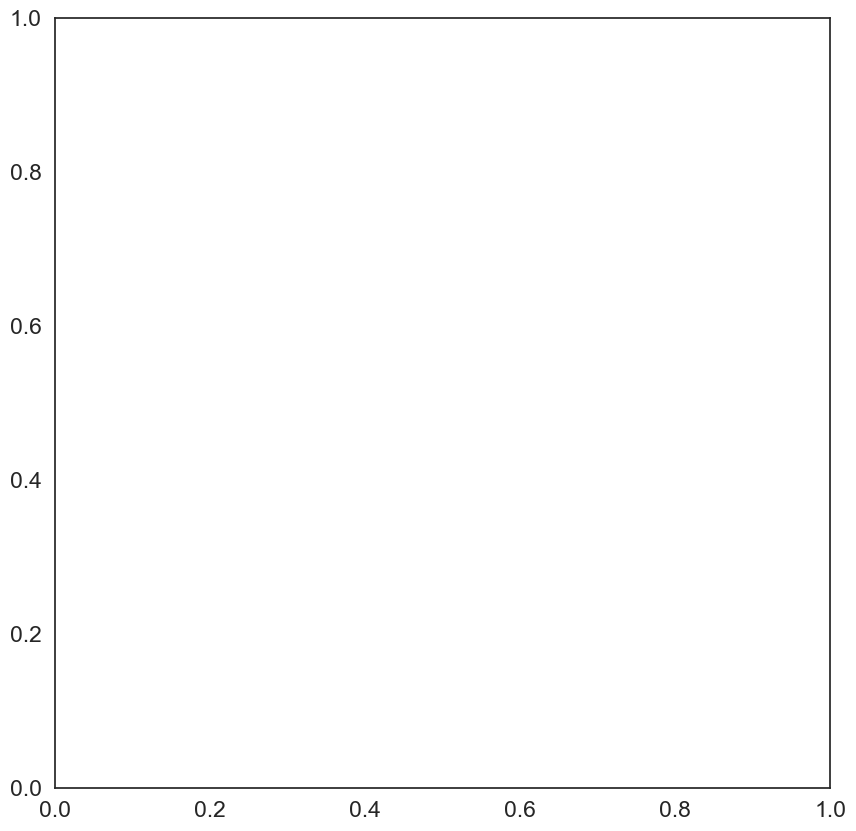

In [77]:
scenarios = ["ssp245", "ssp585"]
member_range = 12
frequency = "A"
period = "1979-01-01-2099-12-16"
start_time = "1979-01-01"
end_time = "2099-12-16"

models = ["ensemble"]
ds_var_names = ["par"] #, "uvb", "uv"]
#ds_var_names = ["uv","uvb"]  #,"uv"]
write_stats_to_file = False
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=1.5)


LMES = ['California Current', 'East Bering Sea', 'Gulf of Alaska',
        'Northern Bering - Chukchi Seas', 'West Bering Sea', 'Sea of Japan',
        'Oyashio Current', 'Kuroshio Current', 'East China Sea',
        'South China Sea', 'Sea of Okhotsk', 'Yellow Sea',
        'Aleutian Islands']

LMES = ['Barents Sea', 'Northern Bering - Chukchi Seas']
#LMES = ['Barents Sea']

for var_name in ds_var_names:
    for LME in LMES:
        create_maps = False
        saved_total_area_lme = None

        f = plt.figure(figsize=(10, 10))
        gs = f.add_gridspec(1, 1)
        ax = f.add_subplot(gs[0, 0])
        sns.set_palette("tab10")
        loop=0
      #  palette_tab10 = sns.color_palette("tab10", 10)
      #  colors = [palette_tab10[0], palette_tab10[1], palette_tab10[3]]


        # Colors from deep default seaborn palette found here:
        # https://github.com/mwaskom/seaborn/blob/master/seaborn/palettes.py
        colors_water = ["#8172B3", "#64B5CD"]

        # We loop over all of the scenarios, ensemble_ids, and models to create a
        # list of dataframes that we eventually concatenate together and plot
        for scenario in scenarios:

            fname_perc = f"../oceanography/light/ncfiles/ensemble/{var_name}_ensemble_perc_{scenario}.nc"
            fname_stats = f"../oceanography/light/ncfiles/ensemble/{var_name}_ensemble_stats_{scenario}.nc"

            if scenario=="ssp585":
                label="SSP5-8.5"
            else:
                label="SSP2-4.5"

            df, df_s, total_area_lme = get_area_averaged_ds(fname_perc, fname_stats, scenario, var_name, LME)

            if df_s is not None:
                saved_total_area_lme = total_area_lme

            outfile = "Figures/{}_ensemble_{}_{}.png".format(var_name.capitalize(), scenario, LME)
           # CMIP6_ridgeplot.ridgeplot("{}_mean".format(var_name),
           #                           None, outfile,
           #                                   glorys=False, depth_threshold=None,
           #                                   ds=ens_stats)

            clim = (df_s["roll_mean"].loc['1980-01-01':'2000-01-01']).mean()
            df_s["rel_change"] = ((df_s["roll_mean"] - float(clim)) / float(clim)) * 100.

            ax.fill_between(df_s["roll_mean"].index,
                df_s["roll_mean"]-df_s["roll_std"],
                            df_s["roll_mean"]+df_s["roll_std"],
                alpha=0.2,
                color=colors_water[loop],
                label=None,
            )

            ax.plot(
                df_s["roll_mean"].index,
                df_s["roll_mean"],
                linewidth=5,
                color=colors_water[loop],
                label=f"{label}",
            )

            ax.tick_params(labelsize=22)
            ax.set_xlabel("", fontsize=20)
            ax.set_ylabel("", fontsize=20)

            if loop==0:
                ax2 = ax.twinx()

            ax2.plot(
                df_s["rel_change"].index,
                df_s["rel_change"],
                linewidth=5,
                linestyle="--",
                color=colors_water[loop],
                label=None,
            )

            ax2.tick_params(labelsize=22)
            ax2.set_xlabel("", fontsize=20)
            ax2.set_ylabel("", fontsize=20)
            ylabels = ['{:,.0%}'.format(y) for y in ax2.get_yticks() / 100.]
            ax2.set_yticklabels(ylabels)
            import matplotlib.dates as mdates
            ax.xaxis.set_major_locator(mdates.YearLocator(base=10))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=-90)
           # ax2.get_legend().remove()
            ax.legend(loc="upper left", frameon=False, fontsize=32)

            if not os.path.exists("Figures"):
                os.makedirs("Figures")

            if loop==1:
                plotfile = "Figures/CMIP6_light_{}_{}.png".format(var_name, LME)
                print("Created figure {}".format(plotfile))
                plt.savefig(plotfile, dpi=200,
                            bbox_inches='tight')


            # Plot individual figure of the total area (km2) where light is more than 1W/m2
            # This is the threshold for where polar cod can feed and gives an indication of
            # changing feeding grounds.

            if var_name in ["par", "par_mean","par_min"]:
                if loop==0:
                    f2 = plt.figure(figsize=(10, 10))
                    gs2 = f2.add_gridspec(1, 1)
                    ax3 = f2.add_subplot(gs2[0, 0])

                # Add extra variable - percentage change in area with light level in
                # water with more than 1W/m2. This is the right side of the plot.
                df["change_open_water"] = (df["roll_mean_area_5"] / float(saved_total_area_lme) * 100.)

                # Plot the results
                # We plot the line for the 5th percentile area surrounded by the 2.5 to 15th percentiles
                # of area where light changes
                ax3.fill_between(df["roll_mean_area_2dot5"].index, df["roll_mean_area_2dot5"], df["roll_mean_area_15"],
                    alpha=0.2,
                    color=colors_water[loop],
                    label=None,
                    )

                ax3.plot(
                    df["roll_mean_area_5"].index,
                    df["roll_mean_area_5"],
                    linewidth=5,
                    color=colors_water[loop],
                    label=f"{label}",
                )

                ax4 = ax3.twinx()
                ax3.plot(
                    df["change_open_water"].index,
                    df["change_open_water"],
                    linewidth=0,
                    color=colors_water[loop],
                    label=None,
                )
                ax3.tick_params(labelsize=22)
                ax3.set_xlabel("", fontsize=20)
                ax3.set_ylabel("", fontsize=20)

                ax4.tick_params(labelsize=22)
                ax4.set_xlabel("", fontsize=20)
                ax4.set_ylabel("", fontsize=20)
                if LME == "Barents Sea":
                    ax3.set_ylim(0.95e6, 1.5e6)
                else:
                    ax3.set_ylim(0.6e6, 1.02e6)

                print("Open water calculations range in area from {} on {} to {} in {}".format(df["roll_mean_area_5"][6],
                                                                                       df.index[6],
                                                                                       df["roll_mean_area_5"][-1],
                                                                                       df.index[-1]))

                ylabels = ['{:,.0%}'.format(y) for y in ax4.get_yticks()]
                ax4.set_yticklabels(ylabels)
                ax3.xaxis.set_major_locator(mdates.YearLocator(base=10))
                ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
                plt.setp(ax3.xaxis.get_majorticklabels(), rotation=-90)

              #  ax3.get_legend().remove()
                ax3.legend(loc="upper left", frameon=False, fontsize=32)

            loop+=1
        plt.show()
        if var_name in ["par", "par_mean","par_min"]:
            plotfile = "Figures/CMIP6_light_{}_{}.png".format("area_open_water", LME)
            print("Created figure {}".format(plotfile))
            plt.savefig(plotfile, dpi=300,bbox_inches='tight')
            plt.show()
